# xSDR: Speaker-Independent Spoken Digit Recognition
This is our solution for the final graded project for the WS22/23 course "_Neural Networks: Theory and Implementation_" at Saarland University.
<br/>
Authors: _Christian Singer, Mhd Jawad Al Rahwanji_
`{chsi00002, mhal00002}@stud.uni-saarland.de`
<br/>
<img src="xSDR.png" height=333>

##### Before we start, we'd like to point out a couple of things:

-- An **Introduction** to the project can be found in `README.md`

-- Some preliminary **Data Exploration** can be found in `DataExploration.ipynb`

### Imports

In [27]:
# add this to ignore warnings from Librosa
import warnings
import os

warnings.filterwarnings('ignore')

In [28]:
base = os.getcwd()

### Task I

In [29]:
# I.1

from model_baseline.data_loading import downsample_spectrogram

downsample_spectrogram

<function model_baseline.data_loading.downsample_spectrogram(spectrogram, num_frames)>

In [30]:
# I.2

from model_baseline.data_loading import create_features

create_features

<function model_baseline.data_loading.create_features(split, num_mels=13, num_frames=10, lazy_mode=True)>

In [31]:
# I.3

from model_baseline.linear_model import classifier

"""
Both penalty and loss parameters were experimented with,
"elasticnet" and "modified_huber" were chosen, respectively.
"""
classifier

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(loss='modified_huber', n_jobs=-1,
                               penalty='elasticnet'))])

In [32]:
# I.4

"""
Confusion matrix analysis:

- Train set CM: We can see that most of the support is concentrated on the diagonal which reflects a very good fit. Nevertheless, there exists some miss-classifications here and there, most notably, struggles with (1-4, 1-7, 1-9) and (8-3, 8-6). All of which can be seen in the precision, recall and f1-score values from the train set report.

- Dev & Test set CMs: In contrast to train set CMs, dev and test CMs exhibit more miss-classifications and amplified confusions. Namely, (1-4, 1-9), (4-1), (5-9), (6-8), (8-3, 8-6) and maybe (9). All of which is reflected in the precision, recall and f1-score values from the dev and test set reports.
"""
os.chdir(base + '/model_baseline')
%run 'linear_model.py'
os.chdir(base)

----------------------------------TRAIN-SET----------------------------------------
Confusion matrix:
[[193   1   1   0   0   0   0   4   0   1]
 [  0 157   0   0   4   3   0  24   0  12]
 [  4   7 179   8   0   0   0   1   1   0]
 [  0   0  12 163   0   2   0  22   0   1]
 [ 14   3   0   0 179   0   1   3   0   0]
 [  0   4   0   0   0 177   0  14   0   5]
 [  0   0   1   6   1   3 162  19   7   1]
 [  2   2   0   1   0   2   2 189   0   2]
 [  0   0   0   0   0   1  25  20 154   0]
 [  1   0   0   0   0   1   0  30   0 168]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       200
           1       0.90      0.79      0.84       200
           2       0.93      0.90      0.91       200
           3       0.92      0.81      0.86       200
           4       0.97      0.90      0.93       200
           5       0.94      0.89      0.91       200
           6       0.85      0.81      0.83       200
          

### Task II

In [33]:
# II.1

from model_neural.transformer_model import TransformerModel
from model_neural.conv1d_model import Conv1dModel, Conv1dMelModel

"""
Answers to sub-questions:

- Yes, both neural models outperform our baseline model. More on that in the next cell.

- Yes, we can clearly see Conv1d over-fit to the train data having an accuracy score of 0.99 compared to its accuracy scores, 0.76 and 0.80 on dev and test sets, respectively.

- Hyperparameter tuning helps stabilize the model by increasing val-accuracy and by doing so achieving better generalization and less overfitting.
"""
print(Conv1dModel) # For exploration purposes, a raw input Conv1d was developed
print(Conv1dMelModel)

print(TransformerModel)

<class 'model_neural.conv1d_model.Conv1dModel'>
<class 'model_neural.conv1d_model.Conv1dMelModel'>
<class 'model_neural.transformer_model.TransformerModel'>


In [34]:
# II.2

"""
Neural-Baseline model comparison:

- Conv1d vs Baseline: Conv1d scored 0.99, 0.78 and 0.81 on train, dev and test sets respectively in terms of accuracy. Compared to the baseline's 0.86, 0.50 and 0.57, Conv1d is clearly superior. Furthermore, Conv1d features a cleaner CM with almost all the support concentrated on the diagonal across all sets. As for the precision, recall and f1-score values, Conv1d, also, mirrors its improved CM with an accordingly robust metric report. Although, it is important to mention that the model still confuses (6) and (8) on dev and test sets as the baseline did.

- Transformer vs Baseline:

"""
os.chdir(base + '/model_neural')
%run 'classification_report.py'
os.chdir(base)

Using: 'cpu' as device for report.
------------------- Conv1dMelModel report -------------------

Confusion matrix of train-set:
 tensor([[191,   0,   7,   0,   0,   0,   2,   0,   0,   0],
        [  0, 200,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 198,   1,   0,   0,   0,   1,   0,   0],
        [  0,   0,   0, 199,   0,   0,   1,   0,   0,   0],
        [  0,   0,   1,   0, 196,   0,   3,   0,   0,   0],
        [  0,   0,   0,   0,   0, 193,   7,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0, 200,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   3, 197,   0,   0],
        [  0,   0,   0,   0,   0,   0,   3,   0, 197,   0],
        [  0,   0,   0,   2,   0,   0,   2,   0,   0, 196]])

Classification report: train-set:
 class   precision   recall   f1-score
     0      1.00       0.95       0.98       
     1      1.00       1.00       1.00       
     2      0.96       0.99       0.98       
     3      0.99       1.00       0.99       
     4     

Using: 'cpu' as device for report.
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 12.185538
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.709354
[t-SNE] KL divergence after 300 iterations: 0.249685


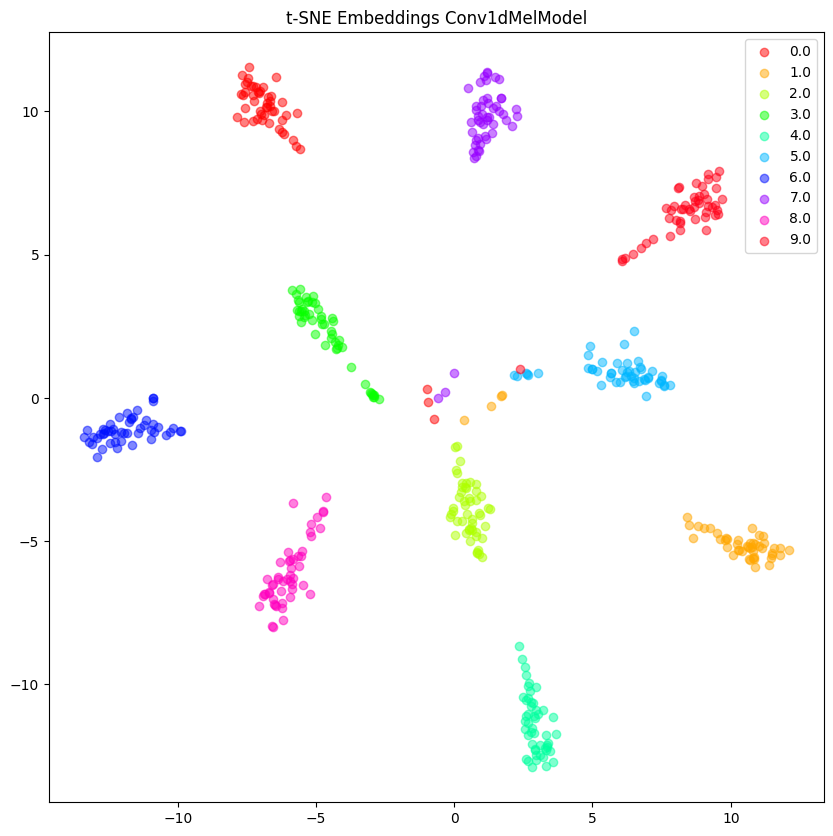

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.000s...
[t-SNE] Computed neighbors for 500 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 2.710413
[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.351685
[t-SNE] KL divergence after 300 iterations: 0.232891


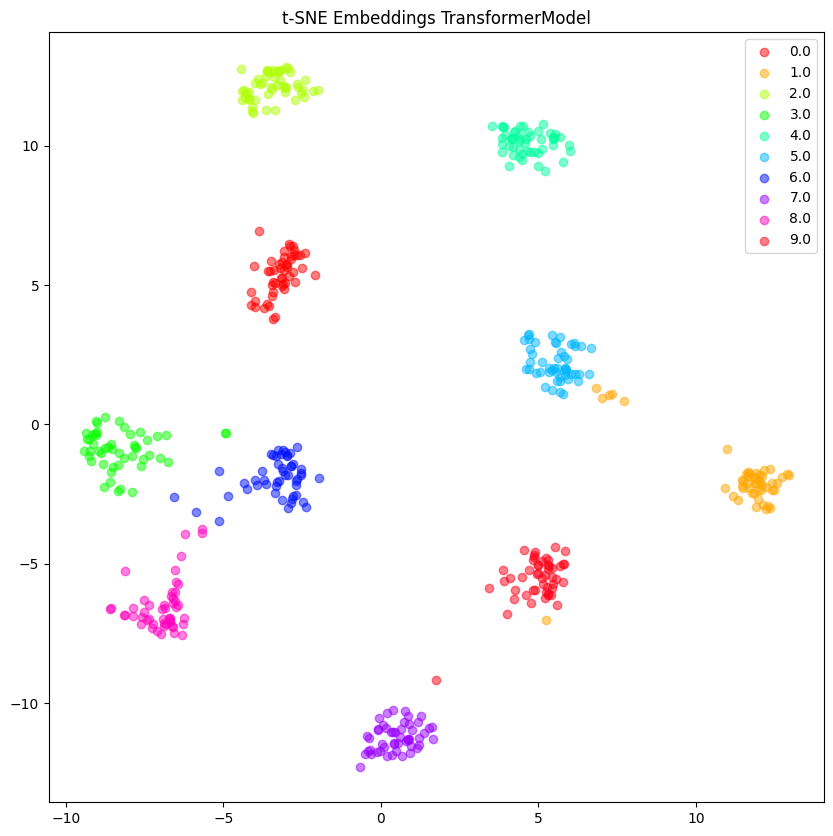

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.033s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 30.252764
[t-SNE] KL divergence after 300 iterations: -0.722199


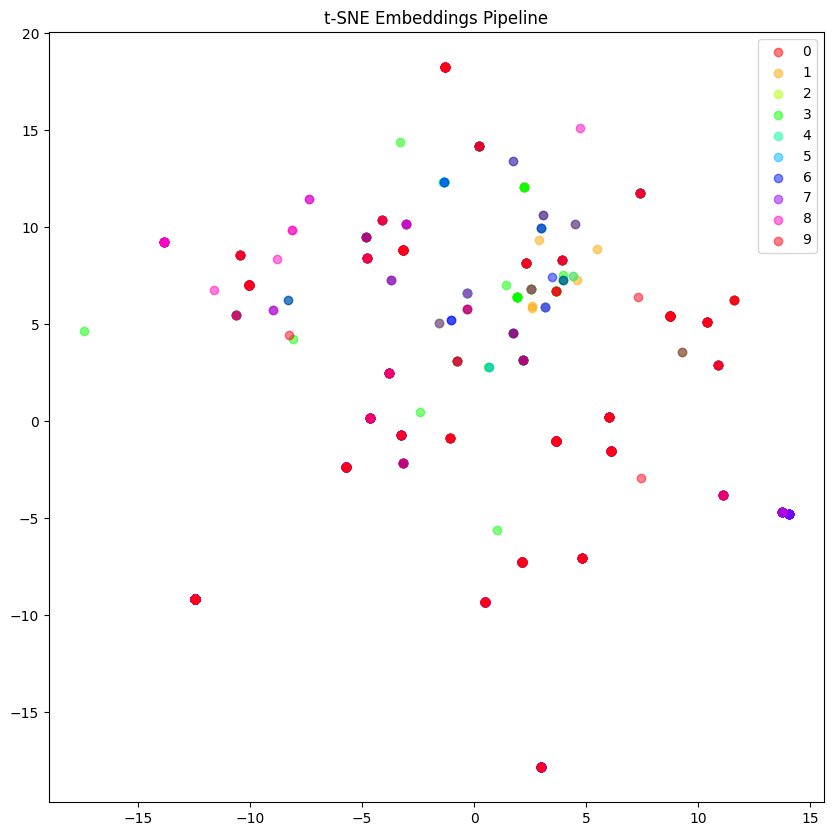

In [35]:
# II.3

"""
Model class separation comparison:

- Conv1d: We can see that the model did a great job separating the different digits in latent space. There exists a slight confusion here and there but overall the classes were clearly well separated.

- Transformer: Same thing was observed for the Transformer model as Conv1d.

- Baseline: This model did a poor job at separation even on the train set we are unable to see clear clusters of classes.
"""
os.chdir(base + "/comparative_analysis")
%run 'tsne_model_embeddings.py'
os.chdir(base)

In [36]:
# II.4

os.chdir(base + "/comparative_analysis")
%run 'statistical_significance_test.py'
os.chdir(base)

When p < 0.5, 2nd model outperforms 1st with [p]
When p > 0.5, 1st model outperforms 2nd with [1 - p]

Sampling 100 times...
p-value of Conv1d x Baseline: 1.0
Sampling 100 times...
p-value of Transformer x Baseline: 1.0
Sampling 100 times...
p-value of Conv1d x Transformer: 0.86


### Task III

In [37]:
# III.1

"""
Answers to sub-questions:

Here we ONLY evaluate the models on the 3 splits. The models have been previously trained on a single speaker (george) and loaded for evaluation.

- During training we've noticed that the training error decreases while the validation loss remains constant and high.

- This means that the models overfit to the single speaker and were unable to generalize and perform well on the other speakers. Since the single speaker set is so small and unvaried, the performance was even worse than that of the same untuned model trained on the complete training split which also overfit.
"""
os.chdir(base + '/model_neural')
%run 'single_speaker_classification_report.py'
os.chdir(base)

Using: 'cpu' as device for report.
------------------- Conv1dMelModel report -------------------

Confusion matrix of train-set:
 tensor([[ 59,  34,  46,   2,   7,   0,   0,  16,  36,   0],
        [  0,  67, 121,   5,   5,   0,   0,   0,   2,   0],
        [  9,   0, 107,  35,   0,   2,   0,  11,  36,   0],
        [  0,   0,  29, 137,   0,   4,   0,   0,  30,   0],
        [  0,  46,  86,   3,  63,   0,   0,   0,   2,   0],
        [  0,  19,  59,   7,  64,  50,   0,   0,   1,   0],
        [  0,   0,   1,  26,   0,  22,  52,  30,  69,   0],
        [  0,   7,  59,  39,  28,   1,   0,  54,  12,   0],
        [  0,   0,  16,  19,   0,   0,   0,   0, 165,   0],
        [  0,  38,  70,  12,  21,   3,   0,   1,   1,  54]])

Classification report: train-set:
 class   precision   recall   f1-score
     0      0.87       0.29       0.44       
     1      0.32       0.34       0.33       
     2      0.18       0.54       0.27       
     3      0.48       0.69       0.56       
     4     

In [38]:
# III.2

"""
CM analysis:

Here our Conv1d model was trained on a single speaker, once with SpecAugment (frequency masking) and once with WavAugment (contrast transform).

- The classification reports, again evaluated on the 3 splits, are thus. The performance on validation sets improved two fold. While single speaker set was also overfit since it contains the original single speaker set that it was trained on.

- Two fold, in the sense that only about 1 digit was recognized before. Now about 2 or so digits are being recognized. As can be seen from inspecting the validation/test set CMs.
"""
os.chdir(base + '/model_neural')
%run 'data_augmentation_classification_report.py'
os.chdir(base)

Using: 'cpu' as device for report.
------------------- Conv1dMelModel report -------------------

Confusion matrix of train-set:
 tensor([[119,   2,  32,   4,  21,   0,   2,   4,  16,   0],
        [  0,  87,  64,   0,  47,   1,   0,   1,   0,   0],
        [ 27,   1, 125,  27,   0,   0,  14,   1,   5,   0],
        [ 20,   3,  62,  97,   3,   0,   8,   5,   2,   0],
        [  0,   0,  93,   1, 106,   0,   0,   0,   0,   0],
        [  0,  71,  25,   0,  36,  64,   0,   0,   2,   2],
        [  0,   6,  38,  17,   0,   0,  64,  46,  29,   0],
        [  1,  74,  25,   2,  29,   0,  11,  54,   4,   0],
        [  0,   0,  68,   4,   1,   0,  12,   0, 115,   0],
        [  0, 121,  11,   0,  23,   0,   0,   0,   1,  44]])

Classification report: train-set:
 class   precision   recall   f1-score
     0      0.71       0.60       0.65       
     1      0.24       0.44       0.31       
     2      0.23       0.62       0.34       
     3      0.64       0.49       0.55       
     4     

In [39]:
# III.3

"""
Answers to sub-questions:

- TODO: Fill with answer to : "Does this model improve over the model without contrastive learning?"

- Discuss your observations.
"""

os.chdir(base + '/model_neural')
%run 'contrastive_learning_classification_report.py'
os.chdir(base)

Using: 'cpu' as device for report.
------------------- Conv1dMelModel report -------------------
